# Test Scripts for CLIP Clustering

In [ ]:
# Download packages - Skip if you already have
!conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
!pip install ftfy regex tqdm
! wget https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz -O bpe_simple_vocab_16e6.txt.gz
!pip install git+https://github.com/openai/CLIP.git

In [1]:
# Download CLIP model
import torch
import clip
from PIL import Image
import time
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Test Run Zero-Shot Classification on a single image

In [311]:
img_filepath = '/media/user/New Volume/TINKERMAN/MemeDataset/reddit_memes/reddit_memes/DpQ6INWaBvhhBzjlmRIqbnkgogw1ug3978SrCj_hyGQ.jpg'

input_text = "This is an image of a dog"

image = preprocess(Image.open(img_filepath)).unsqueeze(0).to(device)

# Input Text for tokenisation
# text = clip.tokenize(["a green snake", "a serpent", "a green animal"]).to(device)
text = clip.tokenize(input_text).to(device)

with torch.no_grad():
    image_encode_time = time.time()
    image_features = model.encode_image(image)
    print(f'Image Encode Time: {time.time() - image_encode_time} secs')
    text_encode_time = time.time()
    text_features = model.encode_text(text)
    print(f'Text Encode Time: {time.time() - text_encode_time} secs')
    
    # This portion of code is to ndo prediction of images based on input text
    predict_time = time.time()
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    print(f'CLIP Predict Time: {time.time() - predict_time} secs')
    
# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
# similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
similarity = image_features.cpu().numpy() @ text_features.cpu().numpy().T
# values, indices = similarity[0].topk(5)

print(similarity)
print(extracted_text)
# print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

# print(f'IMAGE_TENSOR: {image_features.T}')
# print(f'TEXT_TENSOR: {text_features.T}')

Image Encode Time: 0.010491609573364258 secs
Text Encode Time: 0.009916067123413086 secs
CLIP Predict Time: 0.021425485610961914 secs
[[0.3484]]
DsBattery life Samsung Batterylife IPhone12 batter life made with mematic


# Feature Extraction - Using CLIP to extract information
## Define the directory of images and process them sequentially
### - Normalise the image
### - Run forward pass of the model on image and text

In [416]:
image_set_features = torch.empty([0, 512], dtype=torch.float16).to(device)

images = []
img_filename = []
# plt.figure(figsize=(12, 12))

tensor_file_dir = "tensors/"
# image_dir = '/media/user/New Volume/TINKERMAN/MemeDataset/reddit_memes/reddit_memes/'
image_dir = '/media/user/New Volume/TINKERMAN/imagenet_Subset/train'
file_directory = [filename for filename in os.listdir(image_dir) if filename.endswith(".jpg")]
image_count = 0
# Bag the iamge size to limit processing the whole dataset - Can set this to full size if you want
# image_bag = 50
image_bag = len(file_directory)
print(f'No of Files: {image_bag}')

for filename in file_directory:
   
    # Retrieve File name
    name = filename.replace("/media/user/New Volume/TINKERMAN/MemeDataset/reddit_memes/reddit_memes\\", '', 1)
    img_filename.append(name)

    if image_count == image_bag:
        print(f'Reach end of sample size {image_bag}')
        break

    # image = preprocess(Image.open(os.path.join(image_dir, filename)).convert("RGB"))
    image = Image.open(os.path.join(image_dir, filename)).convert("RGB")
    images.append(image)
    
    # image_input = torch.stack([preprocess(img) for img in images]).to(device)
    image_input = preprocess(image).unsqueeze(0).to(device)

    # Perform image encoding
    with torch.no_grad():
        image_encode_time = time.time()
        image_features = model.encode_image(image_input)
        print(f'Image {image_count} Encode Time: {time.time() - image_encode_time} secs')
    
    # Normalisation Image Features
    image_features /= image_features.norm(dim=-1, keepdim=True)
    # Append image batch to list of features
    image_set_features = torch.cat((image_set_features, image_features))

    # Perform OCR on memes - Only run Recognition
    text = ocr.ocr(os.path.join(image_dir, filename))
    boxes = [line[0] for line in text]
    txts = [line[1][0] for line in text]
    scores = [line[1][1] for line in text]

    # Check if text score is low. Else discard
    # Threshold filter > 0.7
    for score in filter(lambda x: x > 0.7, scores):
        extracted_text.append(txts[scores.index(score)])

    joined_text = ' '.join(extracted_text)
    extracted_text.clear()

    # Can either use a generic SimpleTokeniser() function or SPACY's nlp tokeniser
    # Append text-prompts for CLIP encoder in front
    tokenizer = SimpleTokenizer()
    text_tokens = [tokenizer.encode("This is " + joined_text)]
    # text_tokens = list(nlpTokenizer("This is " + joined_text))

    print(f'Token Length: {len(text_tokens[0])} - Tokens: {text_tokens}')

    # Handle out of domain data
    # Check extracted text sentence length - CLIP tokeniser has a limit to text encoder. Need to find a way to work around this
    # Check if return NULL
    if len(text_tokens[0]) == 0:
        text_tokens = ['NULL']

    if len(text_tokens[0]) > 70:
        text_tokens = [text_tokens[0][:70]]
    
    # Define start and end stream
    text_input = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)
    sot_token = tokenizer.encoder['<|startoftext|>']
    eot_token = tokenizer.encoder['<|endoftext|>']

    for i, tokens in enumerate(text_tokens):
        tokens = [sot_token] + tokens + [eot_token]
        text_input[i, :len(tokens)] = torch.tensor(tokens)

    text_input = text_input.cuda()

    # Perform Text Tokenisation - Using CLIP's inbuilt tokenizer
    # tokens = clip.tokenize(sentenceToken).to(device)
    # print(tokens)

    # Perform Text encoding
    with torch.no_grad():
        text_encode_time = time.time()
        text_features = model.encode_text(text_input)
        print(f'Text Encode Time: {time.time() - text_encode_time} secs')
        
    # Normalisation Text Features
    text_features /= text_features.norm(dim=-1, keepdim=True)
    # Append text batch to list of text features
    text_set_features = torch.cat((text_set_features, text_features))
    print(text_set_features.shape)

    # VISUALISATION HERE
    # # texts.append(descriptions[name])
    # plt.imshow(image.permute(1, 2, 0))
    # plt.title(f"{filename}\n{descriptions[name]}")
    # plt.title(f"{filename}")

    # plt.subplot(image_bag/5, 5, len(images))
    # plt.imshow(image)
    # plt.xticks([])
    # plt.yticks([])

    image_count += 1

# plt.tight_layout()
# image.close()

# Create tensor directory to store saved tensors
if not os.path.exists(tensor_file_dir):
    os.mkdir(tensor_file_dir)

# Save pytorch image tensors here
torch.save(image_set_features, os.path.join(tensor_file_dir, 'image_embeddings.pt'))
torch.save(text_set_features, os.path.join(tensor_file_dir, 'text_embeddings.pt'))

No of Files: 5942
Image 0 Encode Time: 0.008415699005126953 secs
[2021/08/05 16:28:03] root INFO: dt_boxes num : 10, elapse : 2.8121237754821777
[2021/08/05 16:28:03] root INFO: rec_res num  : 10, elapse : 0.09298300743103027
Token Length: 14 - Tokens: [[589, 533, 1594, 797, 537, 22856, 1335, 797, 2846, 286, 638, 518, 614, 6906]]
Text Encode Time: 0.010211944580078125 secs
torch.Size([1, 512])
Image 1 Encode Time: 0.007875680923461914 secs
[2021/08/05 16:28:09] root INFO: dt_boxes num : 17, elapse : 5.1827569007873535
[2021/08/05 16:28:09] root INFO: rec_res num  : 17, elapse : 0.14740586280822754
Token Length: 21 - Tokens: [[589, 533, 827, 1043, 537, 1147, 7389, 18119, 14668, 789, 20678, 320, 13125, 2102, 17638, 694, 1417, 2029, 320, 11574, 18785]]
Text Encode Time: 0.011090755462646484 secs
torch.Size([2, 512])
Image 2 Encode Time: 0.009032249450683594 secs
[2021/08/05 16:28:10] root INFO: dt_boxes num : 4, elapse : 0.7404193878173828
[2021/08/05 16:28:10] root INFO: rec_res num  : 4

# Dump image filename list into pickle for reference

In [417]:
import pickle

# image_file_name_pickle = "image_filenames_reddit.pkl"
image_file_name_pickle = "image_filenames_ImageNet.pkl"

open_file = open(os.path.join(tensor_file_dir, image_file_name_pickle), "wb")
pickle.dump(img_filename, open_file)
open_file.close()

# Load Image Tensors and Perform Similarity Matching

[2021/08/05 23:29:11] root INFO: dt_boxes num : 22, elapse : 12.006243228912354
[2021/08/05 23:29:12] root INFO: rec_res num  : 22, elapse : 0.19289588928222656
[[[1008.0, 21.0], [1280.0, 31.0], [1277.0, 113.0], [1005.0, 104.0]], ('One', 0.88829184)]
[[[1744.0, 26.0], [2137.0, 55.0], [2130.0, 147.0], [1738.0, 118.0]], ('Every', 0.98189336)]
[[[942.0, 172.0], [1331.0, 162.0], [1333.0, 253.0], [945.0, 264.0]], ('week', 0.9725558)]
[[[1726.0, 186.0], [2149.0, 193.0], [2148.0, 265.0], [1725.0, 259.0]], ('meme', 0.92577887)]
[[[1025.0, 308.0], [1262.0, 308.0], [1262.0, 403.0], [1025.0, 403.0]], ('not', 0.9927953)]
[[[1607.0, 305.0], [2260.0, 311.0], [2258.0, 428.0], [1606.0, 421.0]], ('template', 0.9998499)]
[[[834.0, 438.0], [1230.0, 453.0], [1226.0, 569.0], [829.0, 555.0]], ('being', 0.99721396)]
[[[2114.0, 449.0], [2238.0, 449.0], [2238.0, 551.0], [2114.0, 551.0]], ('is', 0.97977376)]
[[[1284.0, 469.0], [1452.0, 469.0], [1452.0, 548.0], [1284.0, 548.0]], ('on', 0.89380324)]
[[[1728.0, 46

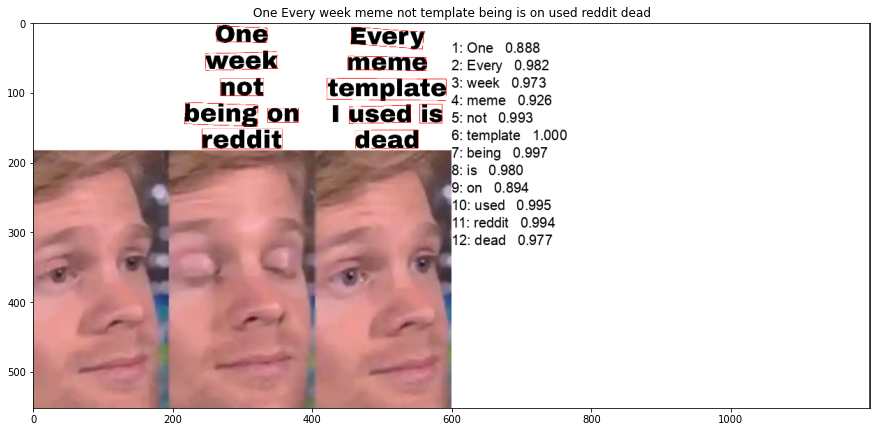

In [460]:
sample_text_extracted = []
# Retrieve Test Image Query
imgSample_filepath = '/media/user/New Volume/TINKERMAN/MemeDataset/reddit_memes/reddit_memes/DU1jSbqReRkAWudLyjv_V3DNyygDmIOEhNnDSuTF6Ts.jpg'
imageSample = Image.open(imgSample_filepath).convert("RGB")

# Perform OCR
# Run both detection and recognition
text_sample = ocr.ocr(imgSample_filepath)

# Print detection frame and recognition result
for line in text_sample:
    print(line)

image_sample = Image.open(imgSample_filepath).convert('RGB')
boxes = [line[0] for line in text_sample]
txts = [line[1][0] for line in text_sample]
scores = [line[1][1] for line in text_sample]

# Check if text score is low. Else discard
# Threshold filter > 0.7
for score in filter(lambda x: x > 0.7, scores):
    sample_text_extracted.append(txts[scores.index(score)])

joined_sampletext = ' '.join(sample_text_extracted)
sample_text_extracted.clear()

# Can either use a generic SimpleTokeniser() function or SPACY's nlp tokeniser
# Append text-prompts for CLIP encoder in front
tokenizer = SimpleTokenizer()
text_tokens = [tokenizer.encode("This is " + joined_sampletext)]
# text_tokens = list(nlpTokenizer("This is " + joined_text))

print(f'Token Length: {len(text_tokens[0])} - Tokens: {text_tokens}')

# Handle out of domain data
# Check extracted text sentence length - CLIP tokeniser has a limit to text encoder. Need to find a way to work around this
# Check if return NULL
if len(text_tokens[0]) == 0:
    text_tokens = ['NULL']

if len(text_tokens[0]) > 70:
    text_tokens = [text_tokens[0][:70]]

# Define start and end stream
text_input = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)
sot_token = tokenizer.encoder['<|startoftext|>']
eot_token = tokenizer.encoder['<|endoftext|>']

for i, tokens in enumerate(text_tokens):
    tokens = [sot_token] + tokens + [eot_token]
    text_input[i, :len(tokens)] = torch.tensor(tokens)

# This input to be fed into Text Encoder
text_input = text_input.cuda()

# Plot for all 3 det, rec and cls
imsample_show = draw_ocr(image_sample, boxes, txts, scores, font_path='/home/user/TINTIN_TDP/PaddleOCR/doc/fonts/german.ttf')

# imsample_show = Image.fromarray(imsample_show)
plt.figure(figsize=(15, 15))
plt.title(joined_sampletext)
plt.imshow(imsample_show)

Image Encode Time: 0.008309125900268555 secs
Text Encode Time: 0.008468389511108398 secs
/media/user/New Volume/TINKERMAN/MemeDataset/reddit_memes/reddit_memes/DU1jSbqReRkAWudLyjv_V3DNyygDmIOEhNnDSuTF6Ts.jpg
/media/user/New Volume/TINKERMAN/MemeDataset/reddit_memes/reddit_memes/UU346cz8xS1KfFjujyqj1Bt4cKz3B2n20oyskiF_rV8.jpg
/media/user/New Volume/TINKERMAN/MemeDataset/reddit_memes/reddit_memes/mocicHgbCccTbxdlFUwlNPETLZwzKPgvDzlO7tyrJaw.jpg
/media/user/New Volume/TINKERMAN/MemeDataset/reddit_memes/reddit_memes/v-1MAluYbTM-ZgNmHusHobcxTfvYDAz8TEfLctdjIgw.jpg
/media/user/New Volume/TINKERMAN/MemeDataset/reddit_memes/reddit_memes/L0vcQJ-JKZXHcMWEWPFeZBFa-xUqCBl3EV2CxwVigDg.jpg
/media/user/New Volume/TINKERMAN/MemeDataset/reddit_memes/reddit_memes/DU1jSbqReRkAWudLyjv_V3DNyygDmIOEhNnDSuTF6Ts.jpg
/media/user/New Volume/TINKERMAN/MemeDataset/reddit_memes/reddit_memes/zCxKb6otnelh9a_k7IwnorhqQuRdF-S36bMk6fZuQjQ.jpg
/media/user/New Volume/TINKERMAN/MemeDataset/reddit_memes/reddit_memes/rySDnh8

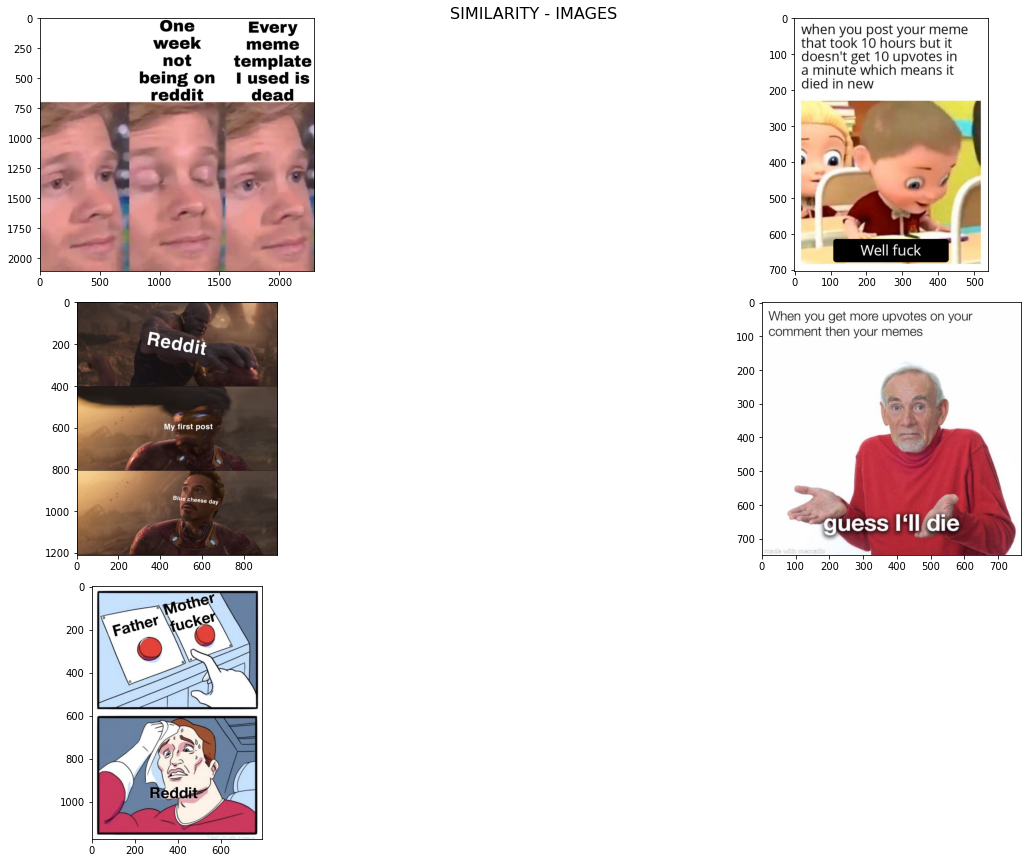

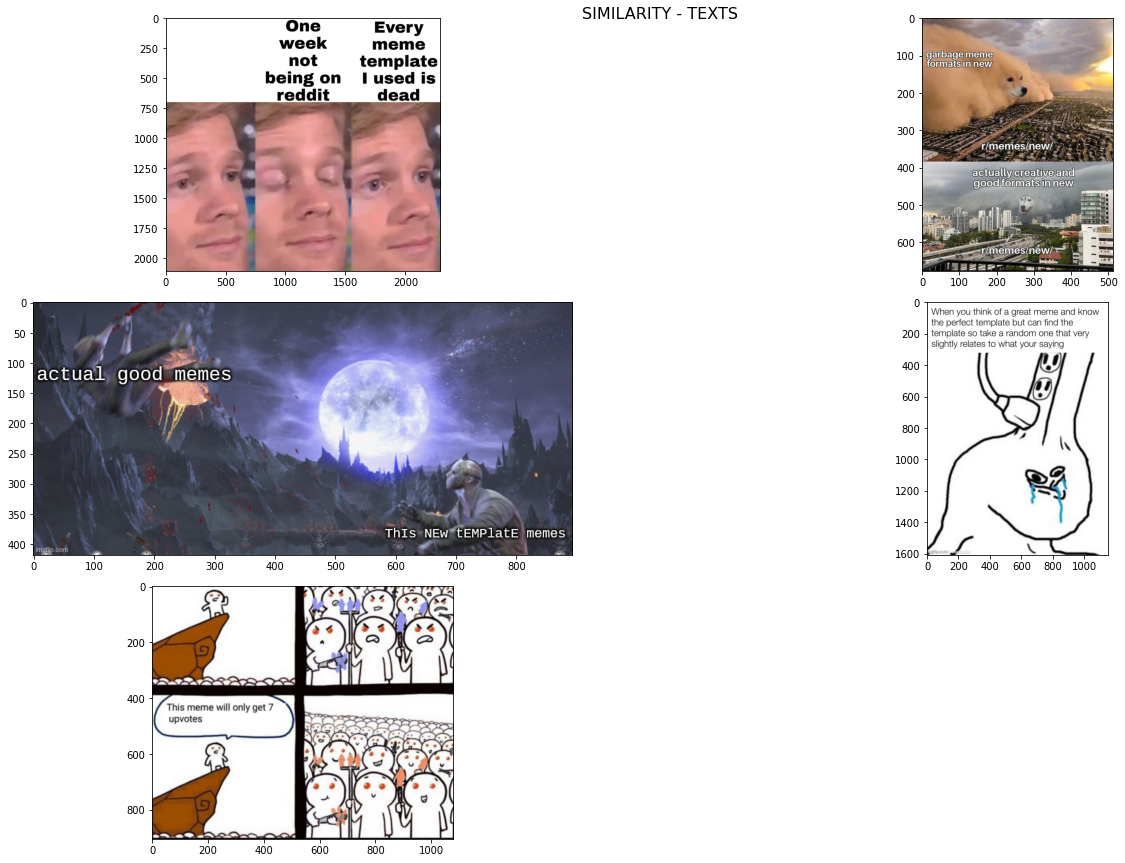

In [461]:
# Extract filenames from pickle
image_file_name_pickle = "image_filenames_reddit.pkl"

open_pickled_file = open(os.path.join(tensor_file_dir, image_file_name_pickle), "rb")
img_filename = pickle.load(open_pickled_file)
open_pickled_file.close()

# Decide on Top_k Values
display_topK = 5
# Preprocess Sample Query
imageSample = preprocess(Image.open(imgSample_filepath)).unsqueeze(0).to(device)

image_tensor = torch.load(tensor_file_dir + 'image_embeddings_reddit.pt')
text_tensor = torch.load(tensor_file_dir + 'text_embeddings_reddit.pt')
image_results_list = []

# Perform Image and Text Encoding
with torch.no_grad():
    image_encode_time = time.time()
    image_features = model.encode_image(imageSample)
    print(f'Image Encode Time: {time.time() - image_encode_time} secs')
    text_encode_time = time.time()
    text_features = model.encode_text(text_input)
    print(f'Text Encode Time: {time.time() - text_encode_time} secs')

image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

# Compute Similarities
similarities_images = image_tensor @ image_features.T
similarities_texts = text_tensor @ text_features.T
values_img, best_photo_idx_img = similarities_images.topk(display_topK, dim=0)
values_text, best_photo_idx_text = similarities_texts.topk(display_topK, dim=0)

similar_image_names_images = []
similar_image_names_texts = []

for id in best_photo_idx_img:
    similar_image_names_images.append(img_filename[id])

for id in best_photo_idx_text:
    similar_image_names_texts.append(img_filename[id])


# Set plot area size
ax1 = plt.figure(figsize=(20, 20))
ax1.suptitle('SIMILARITY - IMAGES', fontsize=16)
for image_list in range(len(similar_image_names_images)):
    print(os.path.join(image_dir, similar_image_names_images[image_list]))
    image_result = Image.open(os.path.join(image_dir, similar_image_names_images[image_list])).convert("RGB")
    image_results_list.append(image_result)
    
    plt.subplot(5, len(similar_image_names_images)/2, len(image_results_list))
    plt.imshow(image_result)
    plt.tight_layout()

image_results_list.clear()

# Set plot area size
ax2 = plt.figure(figsize=(20, 20))
ax2.suptitle('SIMILARITY - TEXTS', fontsize=16)
for image_list in range(len(similar_image_names_texts)):
    print(os.path.join(image_dir, similar_image_names_texts[image_list]))
    image_result = Image.open(os.path.join(image_dir, similar_image_names_texts[image_list])).convert("RGB")
    image_results_list.append(image_result)
    
    plt.subplot(5, len(similar_image_names_texts)/2, len(image_results_list))
    plt.imshow(image_result)
    plt.tight_layout()

image_result.close()